In [27]:
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
import qiskit_aer.noise as noise

from main import *

In [54]:
% reload_ext autoreload
% autoreload 2

secret = np.array([1, 0, 1, 0, 0, 1, 1, 1, 0], dtype=np.byte)

In [55]:
oracle = ClassicalOracle(secret)
solver = ClassicalSolver(oracle)
solution = solver.solve()

print("secret string:".ljust(20, " "), secret)
print("classical solution:".ljust(20, " "), solution)
print("match:".ljust(20, " "), np.array_equal(solution, secret))
print("# of queries:".ljust(20, " "), oracle.query_count)

secret string:       [1 0 1 0 0 1 1 1 0]
classical solution:  [1 0 1 0 0 1 1 1 0]
match:               True
# of queries:        9


In [58]:
qoracle = QuantumOracle(secret)
builder = BVAlgBuilder(qoracle)
builder.create_circuit()

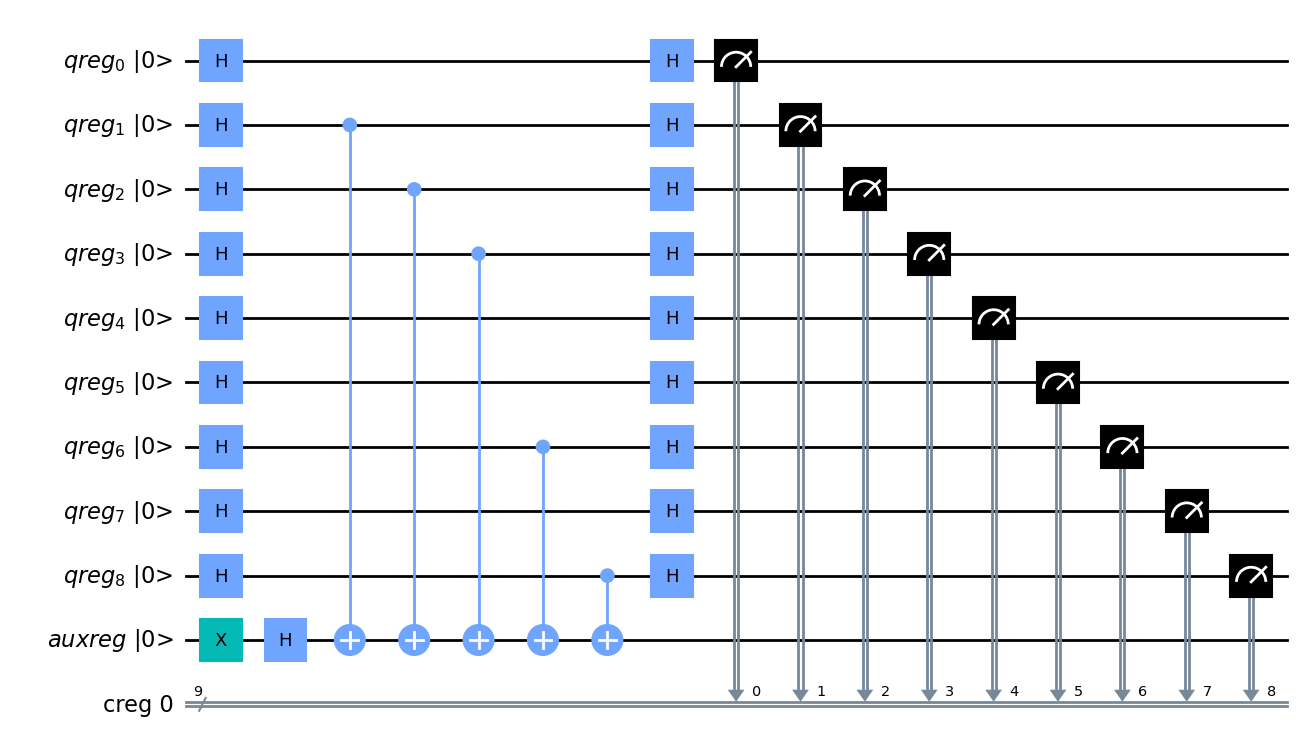

In [60]:
qc = builder.circuit
qc.draw(output="mpl", initial_state=True, plot_barriers=False)

In [80]:
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import pauli_error
from qiskit import transpile

# Error probabilities
prob_1 = 0.2  # 1-qubit gate
prob_2 = 0.2  # 2-qubit gate

p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X', p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X', p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ["h", "z", "x"])
noise_model.add_all_qubit_quantum_error(error_2, ["cx"])

noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

backend = Aer.get_backend("qasm_simulator")

qc_compiled = transpile(builder.circuit, backend)
job = backend.run(qc_compiled, shots=1000, basis_gates=basis_gates, noise_model=noise_model)
result = job.result()
counts = result.get_counts(qc)

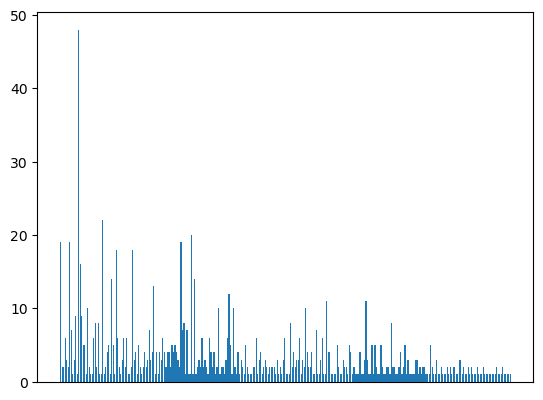

In [81]:
import matplotlib.pyplot as plt

# creating the dataset
courses = list(counts.keys())
values = list(counts.values())

plt.bar(courses, values)

plt.tick_params(
    axis='x',  # changes apply to the x-axis
    which='both',  # both major and minor ticks are affected
    bottom=False,  # ticks along the bottom edge are off
    top=False,  # ticks along the top edge are off
    labelbottom=False)  # labels along the bottom edge are off

plt.show()